In [1]:
# Homework 5
# ASTR 400B
# Emily Walla

In [3]:
# inputs
import numpy as np
import astropy.units as u
import astropy.table as tbl
import matplotlib.pyplot as plt
from Readfile import Read
from CenterOfMass import CenterOfMass as COM
from astropy.constants import G
# convert G to correct units
G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)

In [4]:
# create class MassProfile
class MassProfile:
    # Class to define the mass profile of a galaxy at a snapshot time
    
    def __init__(self, galaxy, snap):
        
        # inputs:
        #       galaxy: a string with galaxy name, such as "MW" or "M31"
        #       snap:  the snapshot number, such as 0, 1, etc
        
        # Initialize instance of this class with the following properties:
        
        # store the name of the galaxy
        self.gname = galaxy
        
        # add a string of the filenumber to the value "000"
        ilbl = "000"+str(snap)
        
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy)+ilbl+".txt"
      
        # read in the data of our desired file
        self.time, self.total, self.data = Read(self.filename) 
    
        # read in the data for the x, y, z positions and the mass
        self.m = self.data["m"]
        self.x = self.data["x"]*u.kpc
        self.y = self.data["y"]*u.kpc
        self.z = self.data["z"]*u.kpc
        
    def MassEnclosed(self, component, r):
        # function that computes the mass enclosed
        #      within a given radius of the COM position
        #      for a specified galaxy & a specified component of galaxy
        
        
        # inputs:
        #      component: the component you want the mass of
        #           either 1 (Halo), 2 (Disk) or 3 (Bulge)
        #      r: the radii (kpc) in which you want to calculate the mass
        #           input r as an array
        
        # returns:
        #      an array of the mass enclosed (Msun) within a given radius
        
        
        # Determine COM Position
        CoM = COM(self.filename,component).COM_P(0.1)
        # distance to the center of mass
        COM_D = np.sqrt(CoM[0]**2 + CoM[1]**2 + CoM[2]**2)
        
        # create an index to extract only the component we are using
        index = np.where(self.data["type"]==component)
        
        # get mass, x, y z  of only the desired component
        part_mass = self.m[index]
        part_x = self.x[index].value - CoM[0]
        part_y = self.y[index].value - CoM[1]
        part_z = self.z[index].value - CoM[2]
        
        # calculate radii for our component
        part_r = np.sqrt( (part_x**2)+(part_y**2)+(part_z**2) )
        
        # find Mass Enclosed within that radius of the COM
        Mass = np.zeros_like(r)
        
        r_index = np.zeros_like(r)
        
        
        i = 0
        for i in range(len(r)):
            # create index to get all points within given radius
            #r_index[i] = np.where(part_r <= r[i])
            Mass[i] = np.sum( part_mass[np.where( part_r < r[i])] )
            
        return Mass*1e10*u.Msun
    
    
    
    def MassEnclosedTotal(self, r):
        # function calculates the total mass enclosed within the given radii
        
        # inputs:
        #      r: a 1D array of radii (kpc)
        
        # returns:
        #      a 1D array of the total masses enclosed within the radii
        
        
        # make a caveat for M33, galaxy with no bulge
        if self.gname == "M33":
            iterate = 2 # M33 only has 2 components
        else:
            iterate = 3 # The other galaxies have 3 components
        
        # make an array to store the masses in
        part_mass = np.zeros((iterate,len(r)))
        
        # get the masses of each component
        i = 0
        for i in range(iterate):
            part_mass[i,:] = self.MassEnclosed(i+1,r)
      
        return np.sum(part_mass,axis=0)
            
    def HernquistMass(self, r, a, Mhalo):
        # function computes the mass enclosed within a given radius
        #     given the theoretical Hernquist profile
        
        
        # inputs:
        #     r: 1D array of radii (kpc) from Center of mass position
        #     a: scale factor
        #     Mhalo: the halo mass of the galaxy (Msun)
        
        # returns:
        #      Returns halo mass (Msun)
        
        return (Mhalo*(r**2))/((a+r)**2)
            
        
    def CircularVelocity(self, component, r):
        # function that computes the circular velocity of the enclosed mass
        # assumes spherical symmetry
        # Vc = (GM/R)^1/2
        
        # inputs:
        #     component: the type of particle you're working with
        #           1 (halo), 2 (disk), 3 (bulge)
        #     r: 1D array of radii (kpc)
        
        # returns:
        #     1D array of circular speeds in units of km/s
        
        M = self.MassEnclosed(component, r)
        
        return np.sqrt(G*M/r)

    def CircularVelocityTotal(self, r):
        # function that calculates the circular velocity of the total enclosed mass
        
        # inputs: r: 1D array of radii (kpc)
        
        # returns: circular velocity of total enclosed mass (km/s)
        
        M = self.MassEnclosedTotal(r)
        
        return np.sqrt(G*M/r)
    
    def HernquistVCirc(self,r, a, Mhalo):
        # computes the circular speed of the Hernquist mass
        
        # inputs:
        #     r: 1D array of radii (kpc) from Center of mass position
        #     a: scale factor
        #     Mhalo: the halo mass of the galaxy (Msun)
        
        # returns: the circular speed of the Hernquist Mass (km/s)
    
        M = self.HernquistMass(r,a,Mhalo)
        return np.round((np.sqrt(G*M/r)),2)

In [7]:

# initialize MassProfile Class for our galaxies
MW = MassProfile("/home/astr400b/VLowRes/MW",0)
M31 = MassProfile("/home/astr400b/VLowRes/M31", 0)
M33 = MassProfile("/home/astr400b/VLowRes/M33", 0)


In [8]:
# create radii array to input
r = np.arange(.00001,30.5,.01)


In [10]:
# find the mass enclosed within the given radii, of each componenet
MW_Halo = MW.MassEnclosed(1,r)
MW_Disk = MW.MassEnclosed(2,r)
MW_Bulge = MW.MassEnclosed(3,r)

M31_Halo = M31.MassEnclosed(1,r)
M31_Disk = M31.MassEnclosed(2,r)
M31_Bulge = M31.MassEnclosed(3,r)

M33_Halo = M33.MassEnclosed(1,r)
M33_Disk = M33.MassEnclosed(2,r)
# M33 doesn't have a bulge

In [11]:
# find the total mass enclosed within the give radii
MW_TotalMass = MW.MassEnclosedTotal(r)
M31_TotalMass = M31.MassEnclosedTotal(r)
M33_TotalMass = M33.MassEnclosedTotal(r)

/home/ewalla02/400b_walla/Homeworks/Homework5/CenterOfMass.py:61: RuntimeWarning: invalid value encountered in double_scalars
  Xcom = np.sum(a*m)/np.sum(m)
/home/ewalla02/400b_walla/Homeworks/Homework5/CenterOfMass.py:63: RuntimeWarning: invalid value encountered in double_scalars
  Ycom = np.sum(b*m)/np.sum(m)
/home/ewalla02/400b_walla/Homeworks/Homework5/CenterOfMass.py:65: RuntimeWarning: invalid value encountered in double_scalars
  Zcom = np.sum(c*m)/np.sum(m)


ValueError: max() arg is an empty sequence

In [12]:
print(M31_Disk[0:10])
print(M33_Disk[0:10])

[       0.        0.        0.        0.        0.  4000000.  6000000.
  8000000.  8000000. 14000000.] solMass
[       0.                0.                0.          3000000.
  6000000.         13000000.         16000000.         28000000.
 35999999.99999999 53000000.00000001] solMass


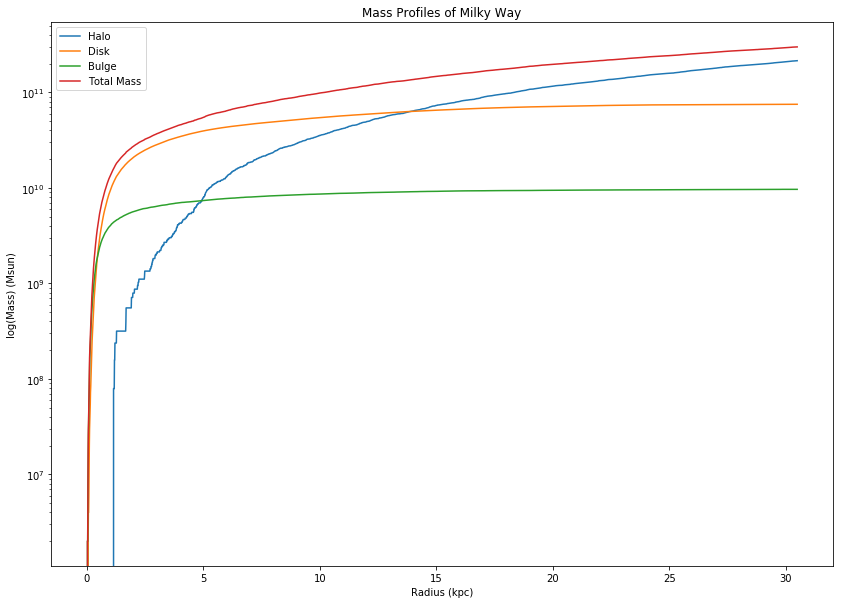

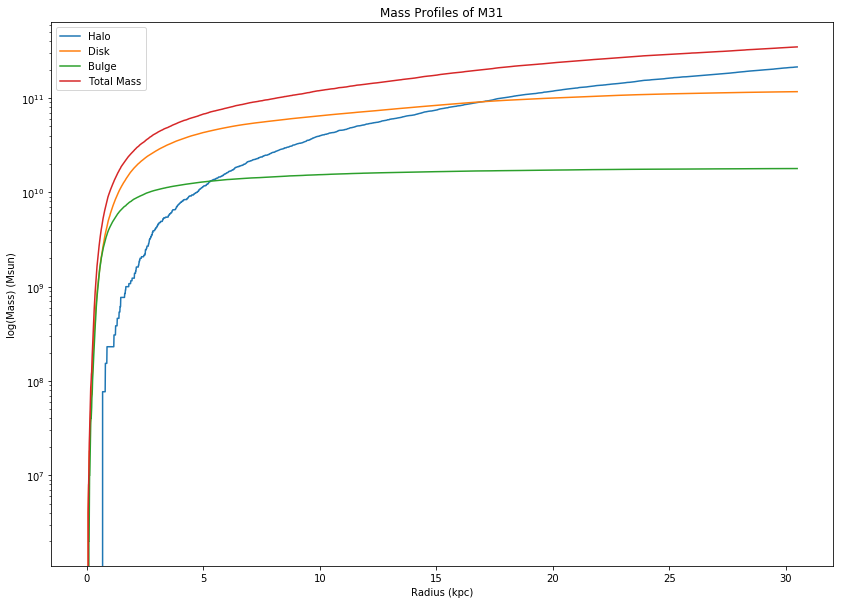

NameError: name 'M33_TotalMass' is not defined

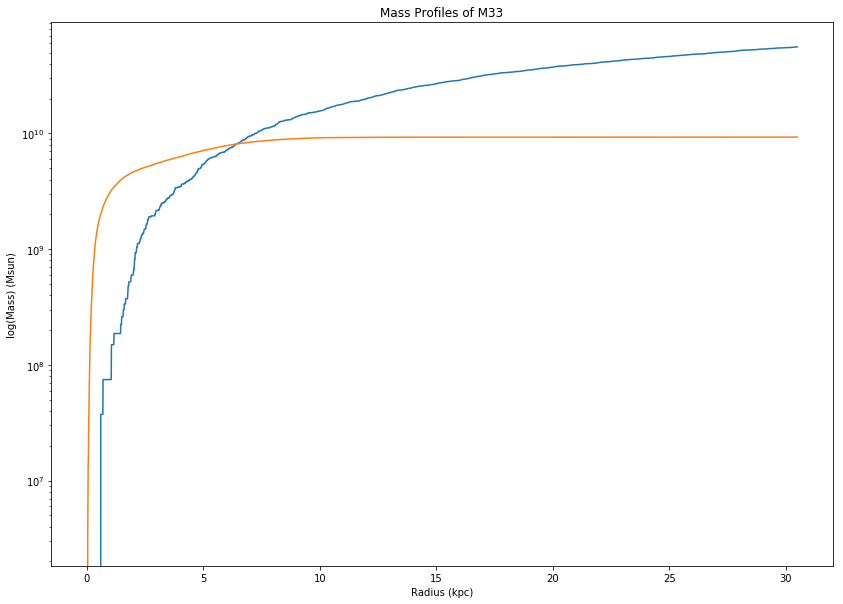

In [13]:
# create plot of mass profiles of each component to radius of 30 kpc

plt.figure(figsize=(14,10))
plt.xlabel("Radius (kpc)")
plt.ylabel("log(Mass) (Msun)")
plt.title("Mass Profiles of Milky Way")
plt.semilogy()
plt.plot(r, MW_Halo, label="Halo")
plt.plot(r, MW_Disk, label="Disk")
plt.plot(r, MW_Bulge, label="Bulge")
plt.plot(r, MW_TotalMass, label="Total Mass")
plt.legend()
plt.show()

plt.figure(figsize=(14,10))
plt.xlabel("Radius (kpc)")
plt.ylabel("log(Mass) (Msun)")
plt.title("Mass Profiles of M31")
plt.semilogy()
plt.plot(r, M31_Halo, label="Halo")
plt.plot(r, M31_Disk, label="Disk")
plt.plot(r, M31_Bulge, label="Bulge")
plt.plot(r, M31_TotalMass, label="Total Mass")
plt.legend()
plt.show()

plt.figure(figsize=(14,10))
plt.xlabel("Radius (kpc)")
plt.ylabel("log(Mass) (Msun)")
plt.title("Mass Profiles of M33")
plt.semilogy()
plt.plot(r, M33_Halo, label="Halo")
plt.plot(r, M33_Disk, label="Disk")
plt.plot(r, M33_TotalMass, label="Total Mass")
plt.legend()
plt.show()

In [16]:
# Determine best fitting hernquist profile for each galaxy

# use total dark matter mass of each galaxy as Mhalo

# make an array for the hernquist radii
r_hernquist = np.arange(.000001,200,.05)

# get the Mass Halo
MW_HernquistHalo = MW.MassEnclosed(1,r_hernquist)
M31_HernquistHalo = M31.MassEnclosed(1,r_hernquist)
M33_HernquistHalo = M33.MassEnclosed(1,r_hernquist)


In [15]:
# guess at a
a = np.arange(0,70,10)


MW_Hernquist = np.zeros((len(a),len(r)))
M31_Hernquist = np.zeros_like(MW_Hernquist)
M33_Hernquist = np.zeros_like(MW_Hernquist)
i = 0
# get the hernquist mass
for i in range(len(a)):
    MW_Hernquist[i,:] = MW.HernquistMass(r,a[i],MW_HernquistHalo[len(r_hernquist)-1])
    M31_Hernquist[i,:] = M31.HernquistMass(r,a[i],M31_HernquistHalo[len(r_hernquist)-1])
    M33_Hernquist[i,:] = M33.HernquistMass(r,a[i],M33_HernquistHalo[len(r_hernquist)-1])

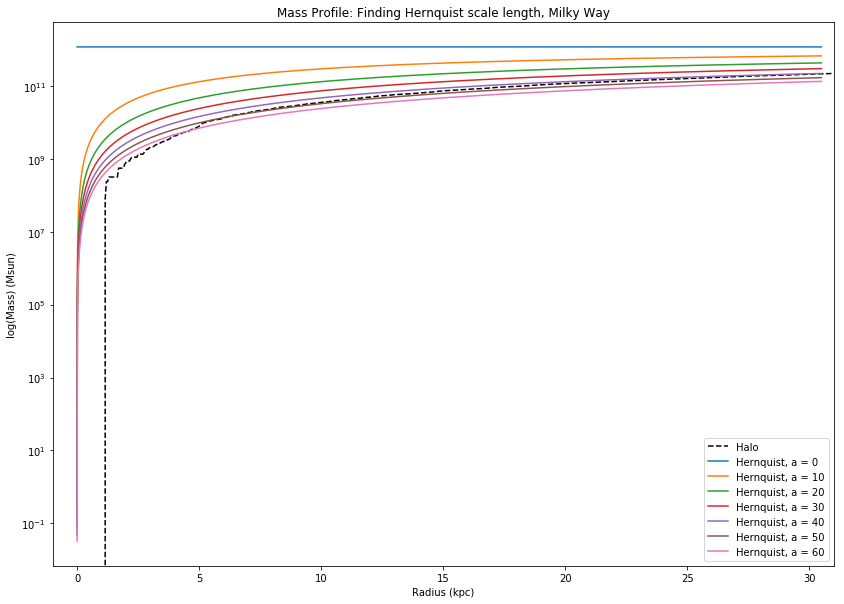

Hernquist best fit scale length at 30 kpc = 40


In [17]:
# create plot of mass profiles of each component of MW to radius of 30 kpc

plt.figure(figsize=(14,10))
plt.xlabel("Radius (kpc)")
plt.ylabel("log(Mass) (Msun)")
plt.title("Mass Profile: Finding Hernquist scale length, Milky Way")
plt.xlim(-1,31)
plt.semilogy()
plt.plot(r_hernquist, MW_HernquistHalo, "k--", label="Halo")
i = 0
for i in range(len(a)):
    plt.plot(r,MW_Hernquist[i], label="Hernquist, a = %s" % (a[i]))
plt.legend()
plt.show()
print("Hernquist best fit scale length at 30 kpc = 40")

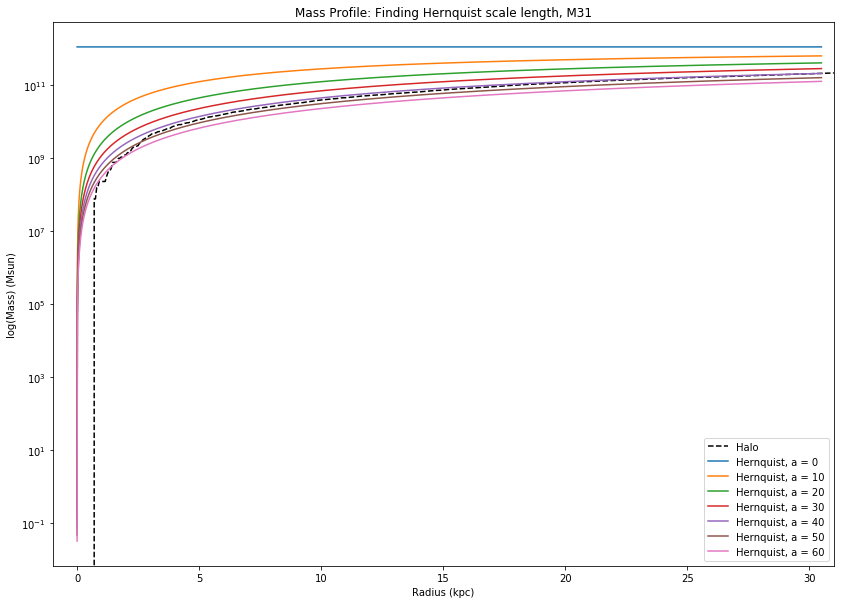

Hernquist best fit scale length at 30 kpc = ?


In [18]:
# do the same as above for M31
# something goes wrong here and I'm not sure how to fix it.
plt.figure(figsize=(14,10))
plt.xlabel("Radius (kpc)")
plt.ylabel("log(Mass) (Msun)")
plt.title("Mass Profile: Finding Hernquist scale length, M31")
plt.xlim(-1,31)
plt.semilogy()
plt.plot(r_hernquist, M31_HernquistHalo, "k--", label="Halo")
i = 0
for i in range(len(a)):
    plt.plot(r,M31_Hernquist[i], label="Hernquist, a = %s" % (a[i]))
plt.legend()
plt.show()
print("Hernquist best fit scale length at 30 kpc = ?")

In [ ]:
# do the same as above for M33
# the same thing goes wrong here as with M31
plt.figure(figsize=(14,10))
plt.xlabel("Radius (kpc)")
plt.ylabel("log(Mass) (Msun)")
plt.title("Mass Profile: Finding Hernquist scale length, M33")
plt.xlim(-1,31)
plt.semilogy()
plt.plot(r_hernquist, M33_HernquistHalo, "k--", label="Halo")
i = 0
for i in range(len(a)):
    plt.plot(r,M33_Hernquist[i], label="Hernquist, a = %s" % (a[i]))
plt.legend()
plt.show()
print("Hernquist best fit scale length at 30 kpc = ?")

In [ ]:
MW_CircSpeedHalo = MW.CircularVelocity(1,r)
MW_CircSpeedDisk = MW.CircularVelocity(2,r)
MW_CircSpeedBulge = MW.CircularVelocity(3,r)
MW_CircSpeedTotal = MW.CircularVelocityTotal(r)

M31_CircSpeedHalo = M31.CircularVelocity(1,r)
M31_CircSpeedDisk = M31.CircularVelocity(2,r)
M31_CircSpeedBulge = M31.CircularVelocity(3,r)
M31_CircSpeedTotal = M31.CircularVelocityTotal(r)

M33_CircSpeedHalo = M33.CircularVelocity(1,r)
M33_CircSpeedDisk = M33.CircularVelocity(2,r)
M33_CircSpeedTotal = M33.CircularVelocityTotal(r)

In [ ]:
a = 40
MW_HernSpeed = MW.HernquistVCirc(r_hernquist,a,MW_HernquistHalo)
M31_HernSpeed = M31.HernquistVCirc(r_hernquist,a,M31_HernquistHalo)
M33_HernSpeed = M33.HernquistVCirc(r_hernquist,a,M33_HernquistHalo)

In [ ]:
plt.figure(figsize=(14,10))
plt.xlabel("Radius (kpc)")
plt.ylabel("Circular Velocity (km/s)")
plt.title("Rotational Velocity Profiles, Milky Way")
plt.xlim(0,30)
plt.plot(r, MW_CircSpeedDisk, label="Disk")
plt.plot(r, MW_CircSpeedBulge, label="Bulge")
plt.plot(r, MW_CircSpeedTotal, label="Total Circular Velocity")
plt.plot(r, MW_CircSpeedHalo, label="Halo")
plt.plot(r_hernquist, MW_HernSpeed, label="Hernquist Speed")
plt.legend()
plt.show()

plt.figure(figsize=(14,10))
plt.xlabel("Radius (kpc)")
plt.ylabel("Circular Velocity (km/s)")
plt.title("Rotational Velocity Profiles, M31")
plt.xlim(0,30)
plt.plot(r, M31_CircSpeedDisk, label="Disk")
plt.plot(r, M31_CircSpeedBulge, label="Bulge")
plt.plot(r, M31_CircSpeedTotal, label="Total Circular Velocity")
plt.plot(r, M31_CircSpeedHalo, label="Halo")
plt.plot(r_hernquist, M31_HernSpeed, label="Hernquist Speed")
plt.legend()
plt.show()

plt.figure(figsize=(14,10))
plt.xlabel("Radius (kpc)")
plt.ylabel("Circular Velocity (km/s)")
plt.title("Rotational Velocity Profiles, M33")
plt.xlim(0,30)
plt.plot(r, M33_CircSpeedDisk, label="Disk")
plt.plot(r, M33_CircSpeedTotal, label="Total Circular Velocity")
plt.plot(r, M33_CircSpeedHalo, label="Halo")
plt.plot(r_hernquist, M33_HernSpeed, label="Hernquist Speed")
plt.legend()
plt.show()